# Data processing

In [2]:
# import packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
%matplotlib inline

In [3]:
# Useful function
def parse_string_to_datetime(x):
    return datetime.strptime(x, '%Y-%m-%d')

### Read stock price CSVs

In [4]:
raw_marekt_data_path = "./data/raw/market_data/"

# current directory csv files;
#  ref: https://stackoverflow.com/a/55245949/9500852
csvs = [x for x in os.listdir(raw_marekt_data_path) if x.endswith('.csv')]
# stats.csv -> stats
fns = [os.path.splitext(os.path.basename(x))[0] for x in csvs]

d = {}
for i in range(len(fns)):
    d[fns[i]] = pd.read_csv(raw_marekt_data_path + csvs[i])

# show read csv result - Disney's stock
d["DIS"]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2011-09-30,26.557592,27.041898,26.407898,26.557592,15135000,0.0,0
1,2011-10-03,26.443124,26.707291,25.527344,25.536150,13899200,0.0,0
2,2011-10-04,25.298400,26.390290,24.822900,26.293430,19000000,0.0,0
3,2011-10-05,26.724900,27.781567,26.689677,27.746346,17823700,0.0,0
4,2011-10-06,27.499790,28.221847,27.314874,28.204235,12659400,0.0,0
...,...,...,...,...,...,...,...,...
2512,2021-09-24,175.300003,176.699997,175.080002,176.000000,5712800,0.0,0
2513,2021-09-27,176.630005,179.449997,175.960007,178.259995,7755000,0.0,0
2514,2021-09-28,177.750000,178.000000,173.860001,174.520004,9133100,0.0,0
2515,2021-09-29,174.250000,174.960007,172.589996,172.679993,6240800,0.0,0


### Stock data count

In [5]:
hk_stock_row_count = 0
us_stock_row_count = 0

for i in range(len(fns)):
    if ".HK" in fns[i]:
        hk_stock_row_count = hk_stock_row_count + len(d[fns[i]])
    else:
        us_stock_row_count = us_stock_row_count + len(d[fns[i]])

print("Rows of HK stocks data: " + str(hk_stock_row_count))
print("Rows of US stocks data: " + str(us_stock_row_count))

Rows of HK stocks data: 121231
Rows of US stocks data: 123839


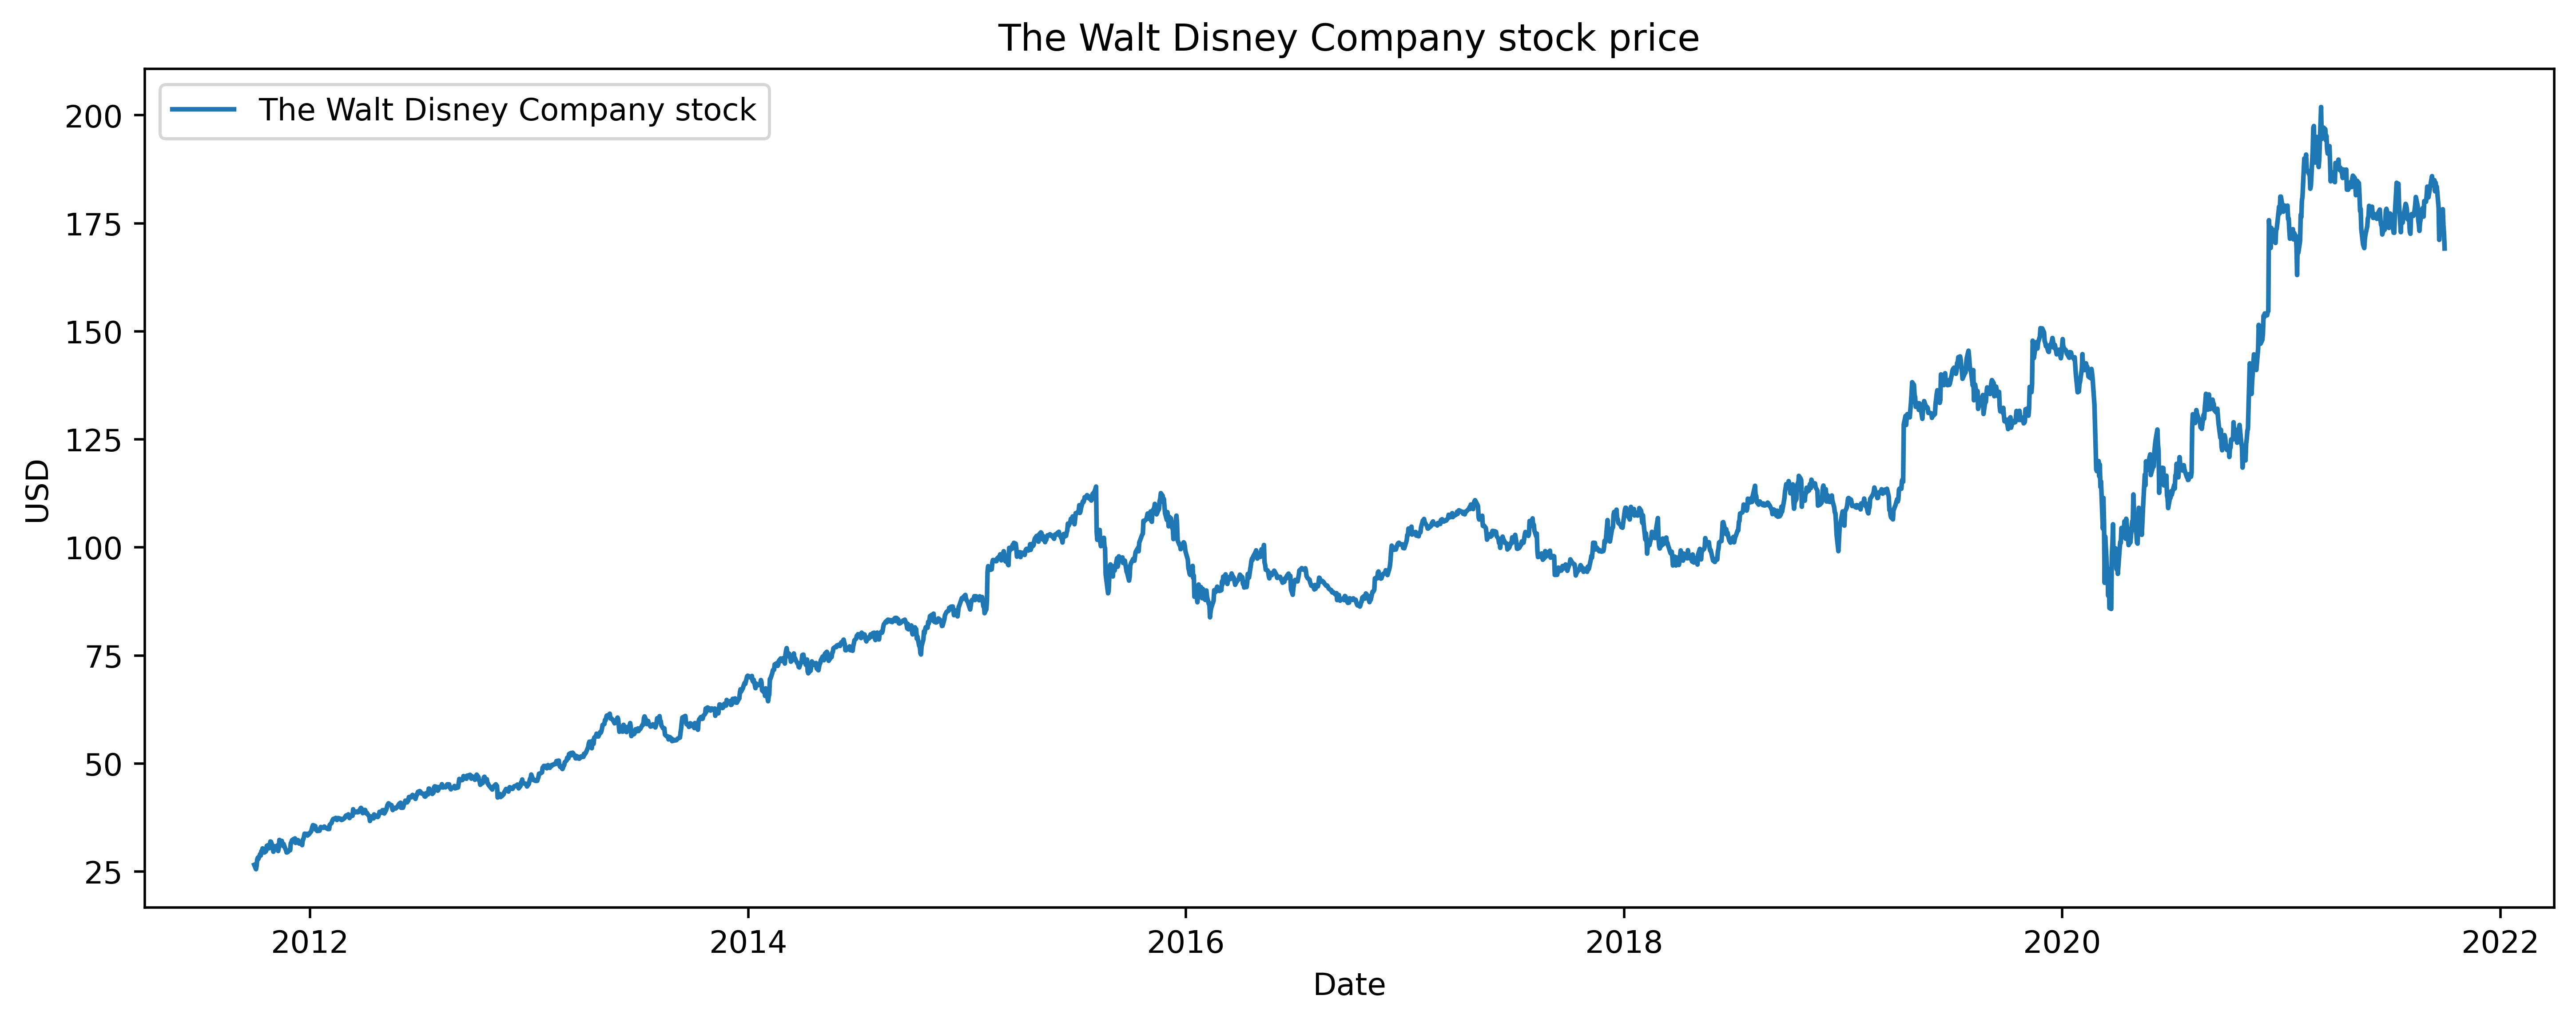

In [6]:
# plot The Walt Disney Company (DIS) stocks price
DIS = d["DIS"]
if not isinstance(DIS["Date"][0], datetime):
    DIS["Date"] = DIS["Date"].apply(parse_string_to_datetime)

plt.figure(figsize=(14, 5), dpi=500)
plt.plot(DIS['Date'], DIS['Close'], label='The Walt Disney Company stock')
# plt.vlines(date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('The Walt Disney Company stock price')
plt.legend()
plt.show()

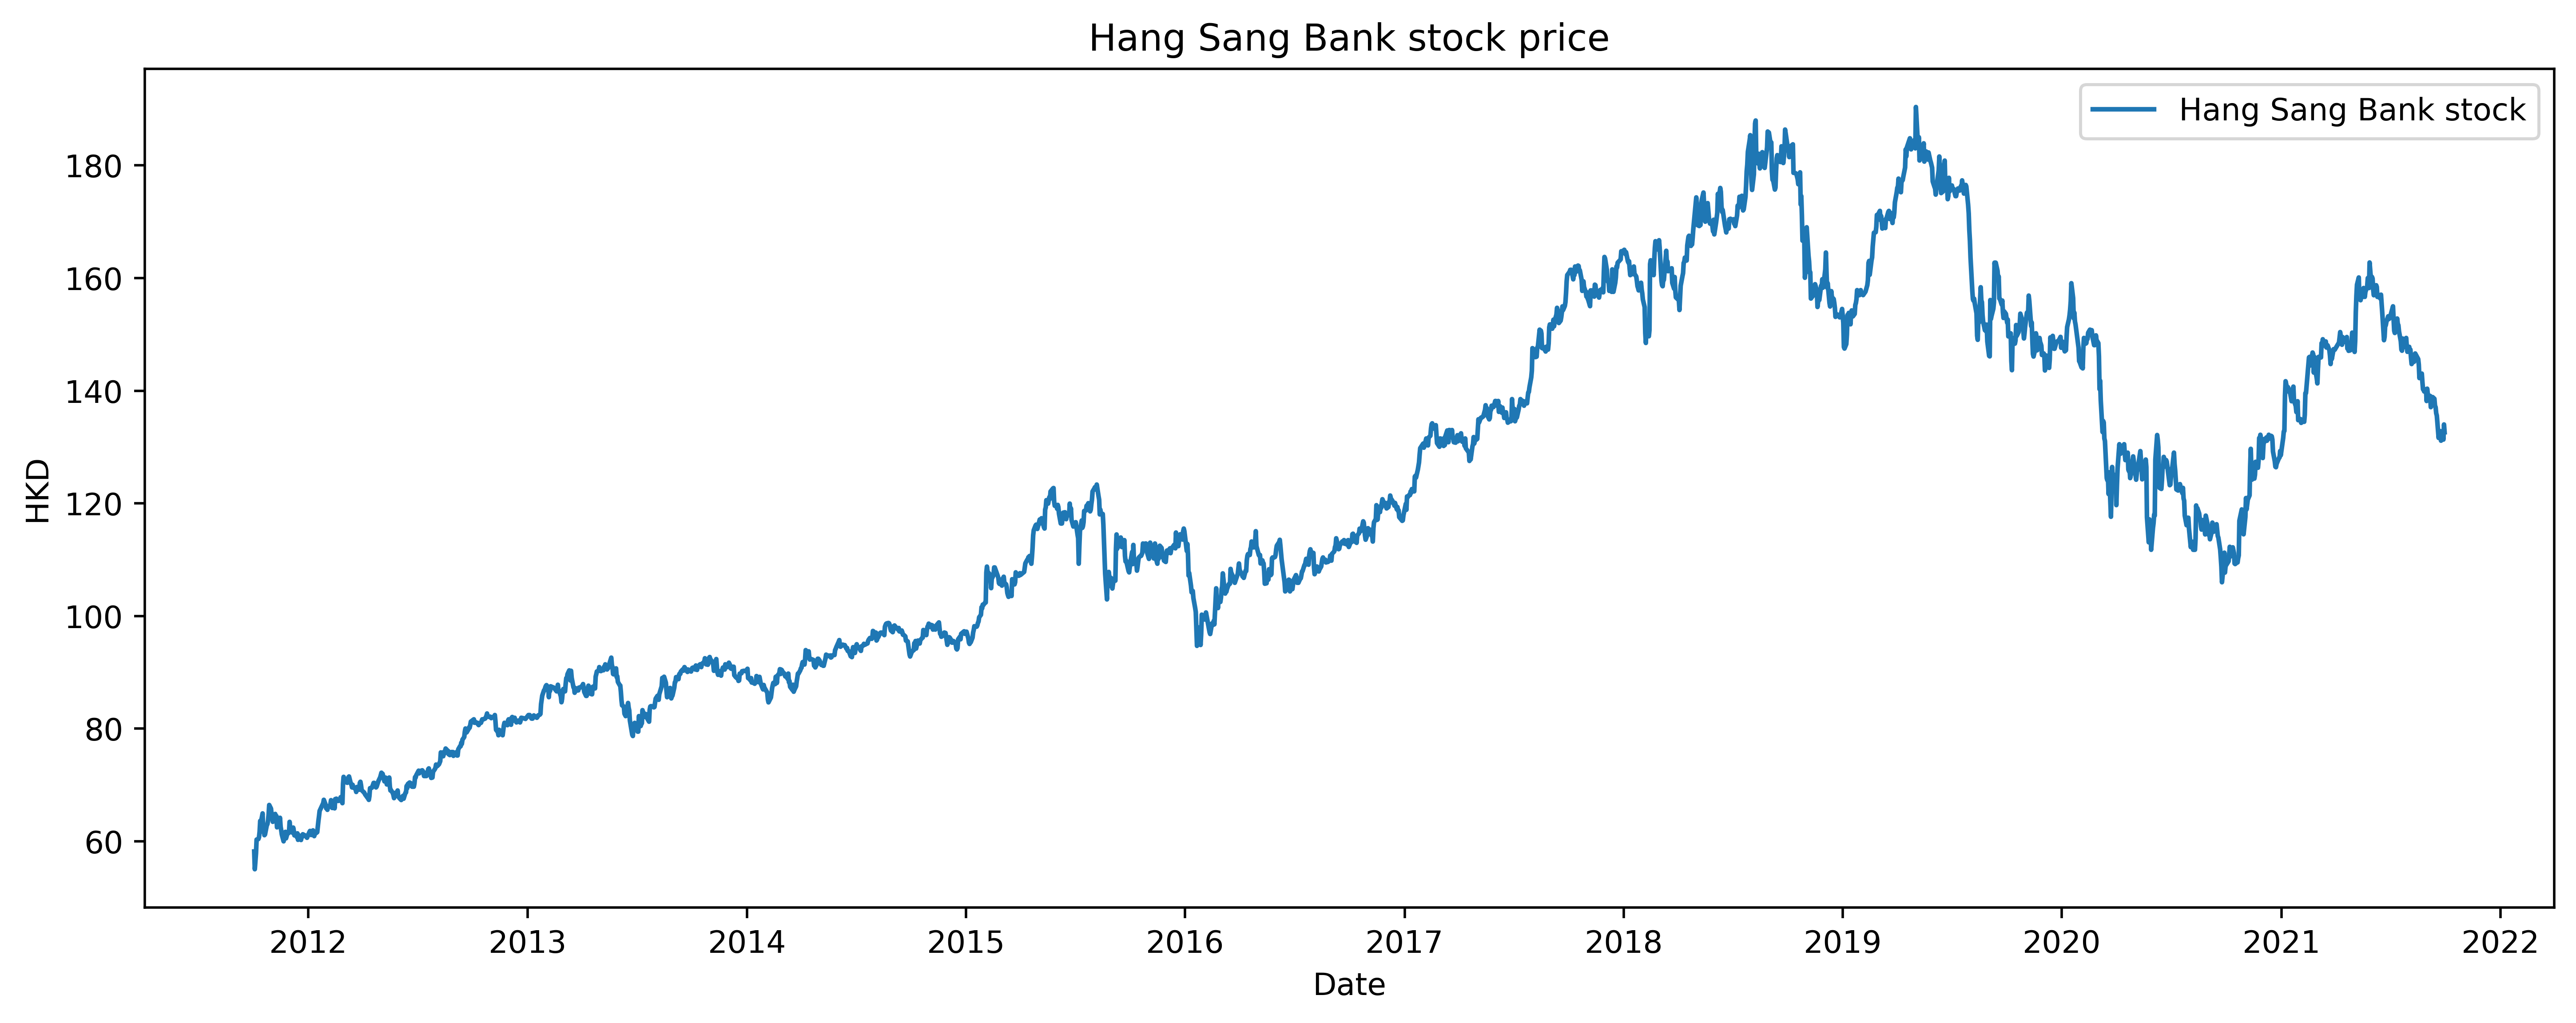

In [7]:
# plot 0011.HK stocks price
HK0011 = d["0011.HK"]
if not isinstance(HK0011["Date"][0], datetime):
    HK0011["Date"] = HK0011["Date"].apply(parse_string_to_datetime)

plt.figure(figsize=(14, 5), dpi=500)
plt.plot(HK0011['Date'], HK0011['Close'], label='Hang Sang Bank stock')
# plt.vlines(date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('HKD')
plt.title('Hang Sang Bank stock price')
plt.legend()
plt.show()

### Data denoising

